# **Modelo para classificação de comentários dos Facebook**

**Algumas observações**

1. Esses comentários foram extraídos de uma página de cerveja (Cerveja Burguesa);
2. O método escolhido foi o de Léxicos de palavras com sentimentos por falta de dados rotulados;
3. Foram utilizados outras técnicas para tentar melhorar o modelo, como stemming, lemmatization e retirar acentos,
mas como foi utilizado um léxico o resultado ficou melhor apenas com as limpezas presentes no modelo;
4. O léxico que foi utilizado como base foi o opLexicon, mas modifiquei o arquivo com base nos comentários dessa
página, o processamento de linguagem natural é uma tarefa difícil e exige adaptação para cada situação específica;
5. A forma de avaliação foi análise empírica baseado na leitura dos cometários Head(60) e Tail(60) de cada
classificação (Positivo, Neutro, Negativo) e corringindo onde o modelo estava errando;
6. As stopwords utlizadas foram totalmente personalizadas, peguei como base algumas stopwords na internet, mas
adicionei muitas conforme fui melhorando o modelo;
7. Comentários negativos não significam que são críticas ou algo falando mal, significa que tem vários elementos
considerados negativos no comentário;
8. Os dados foram extraídos com a ferramente Google Data Studio vinculada com o Supermetrics;
9. Não é um modelo perfeito, mas com base nos comentários lidos e apenas na minha visão subjetiva, posso dizer
que tem uma acurácia de 75%, como sou novato não consegui uma forma melhor de avaliação até o momento.

**Sinta-se a vontade para dar sugestões ou críticas**

# **Importando bibliotecas e base de dados**

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import seaborn as sns
import spacy
from spacy.lang.pt import Portuguese
import nltk
from nltk import tokenize
import re
from string import punctuation
from PIL import Image
%matplotlib inline

Comentarios = pd.read_csv('ZeroComments.csv')

stop_words = pd.read_csv('Stop_Words_Personalizadas.csv')
stop_words = list(stop_words.Stops)

# **Pre-Processamento dos Dados e Criando WordCloud**

In [80]:
Comentarios.head()

,Post comment author,Post comment text
0,LR Lopes,🤜🏼🤛🏼
1,NaN,🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾
2,Raf Fayad,🙏🙏🙏 vem no Papai!
3,Raf Fayad,🙏🙏🙏 delicia!
4,Raf Fayad,🙏🙏🙏 com 1500!


**Renomeando colunas comentários e nomes**

In [81]:
Comentarios.rename(columns={'Post comment text': 'comentarios', 'Post comment author': 'Nome'}, inplace=True)
Comentarios.head()

,Nome,comentarios
0,LR Lopes,🤜🏼🤛🏼
1,NaN,🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾🤘🏾
2,Raf Fayad,🙏🙏🙏 vem no Papai!
3,Raf Fayad,🙏🙏🙏 delicia!
4,Raf Fayad,🙏🙏🙏 com 1500!


**Retirando linhas sem comentários do DataFrame**

In [82]:
Comentarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6140 entries, 0 to 6139
Data columns (total 2 columns):
Nome           6052 non-null object
comentarios    5828 non-null object
dtypes: object(2)
memory usage: 96.1+ KB


In [83]:
Comentarios.dropna(inplace=True)
Comentarios.isna().sum()

Nome           0
comentarios    0
dtype: int64

**Criando variável de tokenização da biblioteca Spacy**

In [84]:
nlp = spacy.load('pt_core_news_sm')

**Criando função para Nuvem de Palavras**

In [85]:
cerveja_mask = np.array(Image.open("latinha_cerveja.png")) # Mask para formato da nuvem de palavras
cerveja_color = np.array(Image.open("cerveja_burguesa.png"))# Imagem para gerar as cores das palavras
image_colors = ImageColorGenerator(cerveja_color) # Função da biblioteca WordCloud para gerar as cores

In [86]:
def nuvem_de_palavras(texto, coluna_texto): # Função para gerar a nuvem de palavras e salvar a imagem gerada
    todas_palvaras = ' '.join([texto for texto in texto[coluna_texto]])

    nuvem_palavras = WordCloud(font_path='Montserrat-ExtraBold.ttf', width=1280, height=720, color_func=image_colors, mask=cerveja_mask, background_color='white', max_font_size = 250, max_words=200, collocations = True, contour_width=10, contour_color='black',random_state=4).generate(todas_palvaras)
    nuvem_palavras.to_file("Nuvem_de_Palavras.png")
    plt.figure(figsize = (10, 7))
    plt.imshow(nuvem_palavras, interpolation ='bilinear')
    plt.axis('off')
    plt.show()

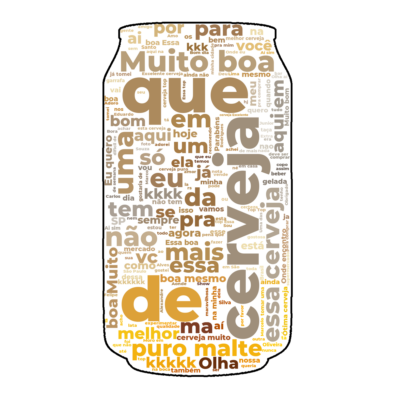

In [87]:
nuvem_de_palavras(Comentarios, 'comentarios')

**Removendo comentários duplicados**

In [88]:
Comentarios.comentarios.count()

5740

In [89]:
Comentarios.drop_duplicates(['comentarios'], inplace=True)

In [90]:
Comentarios.comentarios.count()

5433

**Removendo links, virgulas, ponto e virgulas, números e deixando em caixa baixa.**

In [91]:
def Limpeza_dados(comentarios):
    comentarios = re.sub(r"http\S+", "", comentarios).lower()
    comentarios = re.sub(r"[-|0-9]", "", comentarios).lower()
    comentarios = re.sub(r'[-./?!,":;()\']', ' ', comentarios).lower()
    return (comentarios)

Comentarios['comentarios_1'] = [Limpeza_dados(i) for i in Comentarios.comentarios]

In [92]:
Comentarios.head()

,Nome,comentarios,comentarios_1
0,LR Lopes,🤜🏼🤛🏼,🤜🏼🤛🏼
2,Raf Fayad,🙏🙏🙏 vem no Papai!,🙏🙏🙏 vem no papai
3,Raf Fayad,🙏🙏🙏 delicia!,🙏🙏🙏 delicia
4,Raf Fayad,🙏🙏🙏 com 1500!,🙏🙏🙏 com
5,Raf Fayad,🙏🙏🙏 a puro malte dos sonhos!,🙏🙏🙏 a puro malte dos sonhos


**Removendo letras repetidas**

In [93]:
# Importando léxico de palavras
op_lexico =  pd.read_csv('opLexico_Facebook_Burguesa.txt', header=None,
                         names=('Lexico', 'Emoji', 'Polaridade', 'Metodo'), index_col=False)
op_lexico.head()

,Lexico,Emoji,Polaridade,Metodo
0,=[,emot,-1,A
1,=@,emot,-1,A
2,=p,emot,-1,A
3,=P,emot,-1,A
4,=x,emot,-1,A


In [94]:
def RemoveLetrasRepetidas(comentario): # Função para remover letras repetidas
    comentario = nlp(comentario)
    palavras = list()
    for palavra in comentario:
        if palavra.text not in list(op_lexico.Lexico):
            palavras.append(re.compile(r'(.)\1{1,}', re.IGNORECASE).sub(r'\1', palavra.text))
        else:
            palavras.append(palavra.text)
    return (" ".join(palavras))

Comentarios['comentarios_2'] = [RemoveLetrasRepetidas(i) for i in Comentarios.comentarios_1]

In [95]:
Comentarios[10:15]

,Nome,comentarios,comentarios_1,comentarios_2
13,Barbara Nascimento,🙋,🙋,🙋
16,Fatima Araujo,🙆🙆🙆🙆🙆,🙆🙆🙆🙆🙆,🙆 🙆 🙆 🙆 🙆
17,Alan Diniz,😱,😱,😱
18,DoN'egro Lennyh,😨😨😨😨😨😨😨😨😨😨oi,😨😨😨😨😨😨😨😨😨😨oi,😨 😨 😨 😨 😨 😨 😨 😨 😨 😨 oi
19,Regiane Casarin,😜,😜,😜


**Removendo Stop Words e Pontuações**

In [96]:
# Importando pontuações da biblioteca NLTK
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

In [97]:
def RemoveStopWords(comentario): # Função para remover stopwords e pontuações
    comentario = nlp(comentario)
    palavras = [palavra.text for palavra in comentario if palavra.text not in stop_words and palavra.text
                not in pontuacao]
    return (" ".join(palavras))

Comentarios['comentarios_3'] = [RemoveStopWords(i) for i in Comentarios.comentarios_2]

In [98]:
Comentarios.head()

,Nome,comentarios,comentarios_1,comentarios_2,comentarios_3
0,LR Lopes,🤜🏼🤛🏼,🤜🏼🤛🏼,🤜 🏼 🤛 🏼,🤜 🏼 🤛 🏼
2,Raf Fayad,🙏🙏🙏 vem no Papai!,🙏🙏🙏 vem no papai,🙏 🙏 🙏 vem no papai,🙏 🙏 🙏 papai
3,Raf Fayad,🙏🙏🙏 delicia!,🙏🙏🙏 delicia,🙏 🙏 🙏 delicia,🙏 🙏 🙏 delicia
4,Raf Fayad,🙏🙏🙏 com 1500!,🙏🙏🙏 com,🙏 🙏 🙏 com,🙏 🙏 🙏
5,Raf Fayad,🙏🙏🙏 a puro malte dos sonhos!,🙏🙏🙏 a puro malte dos sonhos,🙏 🙏 🙏 a puro malte dos sonhos,🙏 🙏 🙏 puro malte sonhos


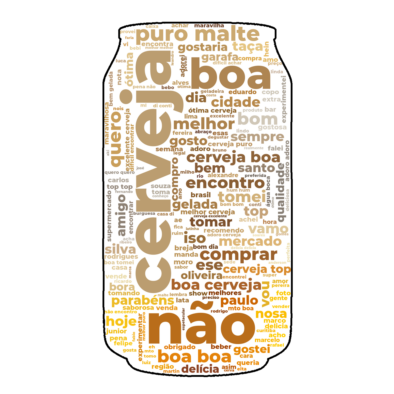

In [99]:
nuvem_de_palavras(Comentarios, 'comentarios_3')

# **Criando modelo de classificação de comentários**

**Atribuindo classificações para os comentários**

In [100]:
op_lexico.head()

,Lexico,Emoji,Polaridade,Metodo
0,=[,emot,-1,A
1,=@,emot,-1,A
2,=p,emot,-1,A
3,=P,emot,-1,A
4,=x,emot,-1,A


**Função para classificar os comentários como Positivo, Neutro ou Negativo e atribuir pontuação**

In [101]:
pontos = []
def Score_sentimento(comentario):
    comentario = nlp(comentario)
    sentimento = []
    for palavra in comentario:
        if palavra.text not in list(op_lexico.Lexico):
            sentimento.append(0)
        else:
            polaridade = op_lexico.loc[op_lexico['Lexico'] == palavra.text, ['Polaridade']]
            polaridade = list(polaridade['Polaridade'])
            polaridade = polaridade[0]
            sentimento.append(polaridade)
    score = sum(sentimento)
    pontos.append(score)
    if score > 0:
        return 'Positivo'
    elif score == 0:
        return 'Neutro'
    else:
        return 'Negativo'
    
Comentarios['classificacao'] = [Score_sentimento(i) for i in Comentarios.comentarios_3]

In [102]:
Comentarios['pontuacao'] = pontos

In [103]:
Comentarios.comentarios_3.count()

5433

In [104]:
Comentarios.drop_duplicates(['comentarios_3'], inplace=True)
Comentarios.comentarios_3.dropna(inplace=True)

In [105]:
Comentarios.comentarios_3.count()

4729

In [106]:
Comentarios[Comentarios['classificacao']=='Positivo']

,Nome,comentarios,comentarios_1,comentarios_2,comentarios_3,classificacao,pontuacao
2,Raf Fayad,🙏🙏🙏 vem no Papai!,🙏🙏🙏 vem no papai,🙏 🙏 🙏 vem no papai,🙏 🙏 🙏 papai,Positivo,3
3,Raf Fayad,🙏🙏🙏 delicia!,🙏🙏🙏 delicia,🙏 🙏 🙏 delicia,🙏 🙏 🙏 delicia,Positivo,4
4,Raf Fayad,🙏🙏🙏 com 1500!,🙏🙏🙏 com,🙏 🙏 🙏 com,🙏 🙏 🙏,Positivo,3
5,Raf Fayad,🙏🙏🙏 a puro malte dos sonhos!,🙏🙏🙏 a puro malte dos sonhos,🙏 🙏 🙏 a puro malte dos sonhos,🙏 🙏 🙏 puro malte sonhos,Positivo,3
6,Raf Fayad,🙏🙏🙏 a puro malte brasileira!,🙏🙏🙏 a puro malte brasileira,🙏 🙏 🙏 a puro malte brasileira,🙏 🙏 🙏 puro malte brasileira,Positivo,3
...,...,...,...,...,...,...,...
5788,Solange Novaes,(( as cervejas 1500 da vida já deram tantas m...,as cervejas da vida já deram tantas músic...,as cervejas da vida já deram tantas músi...,cervejas vida deram tantas músicas,Positivo,1
5801,Oseias Ribeiro Rosa,#TOP!!!! 👍,#top 👍,# top 👍,top 👍,Positivo,2
5813,Paulo Marcos,#DasBOAS\n👏👏👏,#dasboas\n👏👏👏,# dasboas \n 👏 👏 👏,dasboas \n 👏 👏 👏,Positivo,3
5814,Márcio Célio,#Boa!!!Ai amor Ká Mayumi?,#boa ai amor ká mayumi,# boa ai amor ká mayumi,boa amor ká mayumi,Positivo,2


In [107]:
Comentarios[Comentarios['classificacao']=='Neutro']

,Nome,comentarios,comentarios_1,comentarios_2,comentarios_3,classificacao,pontuacao
0,LR Lopes,🤜🏼🤛🏼,🤜🏼🤛🏼,🤜 🏼 🤛 🏼,🤜 🏼 🤛 🏼,Neutro,0
16,Fatima Araujo,🙆🙆🙆🙆🙆,🙆🙆🙆🙆🙆,🙆 🙆 🙆 🙆 🙆,🙆 🙆 🙆 🙆 🙆,Neutro,0
18,DoN'egro Lennyh,😨😨😨😨😨😨😨😨😨😨oi,😨😨😨😨😨😨😨😨😨😨oi,😨 😨 😨 😨 😨 😨 😨 😨 😨 😨 oi,😨 😨 😨 😨 😨 😨 😨 😨 😨 😨 oi,Neutro,0
19,Regiane Casarin,😜,😜,😜,😜,Neutro,0
36,Raf Fayad,😉😉😉,😉😉😉,😉 😉 😉,😉 😉 😉,Neutro,0
...,...,...,...,...,...,...,...
5807,Leandro Pereira,#Descubra1500 !\nMudando os conceitos !,#descubra \nmudando os conceitos,# descubra \n mudando os conceitos,descubra \n mudando conceitos,Neutro,0
5818,Marcelo Eduardo,#1500puromalte,#puromalte,# puromalte,puromalte,Neutro,0
5823,Wender Azevedo,#1500 cerveja puro malte,# cerveja puro malte,# cerveja puro malte,cerveja puro malte,Neutro,0
5826,Rafael Argueira,"""dispensa legenda"" já é uma legenda... ;)",dispensa legenda já é uma legenda,dispensa legenda já é uma legenda,dispensa legenda legenda,Neutro,0


In [108]:
Comentarios[Comentarios['classificacao']=='Negativo']

,Nome,comentarios,comentarios_1,comentarios_2,comentarios_3,classificacao,pontuacao
125,Paulo Junior Sccp,ótima cerveja e péssimo marketing!!! Como semp...,ótima cerveja e péssimo marketing como semp...,ótima cerveja e péssimo marketing como sempr...,ótima cerveja péssimo marketing sempre difí...,Negativo,-2
147,André Nascimento,Ótima cerveja. Sempre faço uma degustação em c...,ótima cerveja sempre faço uma degustação em c...,ótima cerveja sempre faço uma degustação em ...,ótima cerveja sempre degustação casa pen...,Negativo,-1
160,Reginaldo Rejani,Ótima cerveja pena que não Temos em Dracena,ótima cerveja pena que não temos em dracena,ótima cerveja pena que não temos em dracena,ótima cerveja pena não dracena,Negativo,-1
193,Ernandes Lourival Golfette,É uma Merda!!!!,é uma merda,é uma merda,merda,Negativo,-1
198,Juliano Dal Ponte,É não patentiei a marca! Tem até uma transport...,é não patentiei a marca tem até uma transport...,é não patentiei a marca tem até uma transpor...,não patentiei marca transportadora marca,Negativo,-1
...,...,...,...,...,...,...,...
5709,Dalila Brito Rita,A contradição da foto de publicidade da cervej...,a contradição da foto de publicidade da cervej...,a contradição da foto de publicidade da cervej...,contradição foto publicidade cerveja dizendo p...,Negativo,-1
5712,Jorge Fernandes,A cerveja é ótima... aí mais pra mim não desce...,a cerveja é ótima aí mais pra mim não desce...,a cerveja é ótima aí mais pra mim não desce ...,cerveja ótima não desce não ese petisco ...,Negativo,-1
5717,Alexandre Miguel,A cerveja 1500 vai mudar Oo nome,a cerveja vai mudar oo nome,a cerveja vai mudar o nome,cerveja mudar,Negativo,-1
5730,Vinícius H. Masutti,"A 1500 ao invés de ensinar as pessoas a beber,...",a ao invés de ensinar as pessoas a beber con...,a a o invés de ensinar as pesoas a beber c...,invés ensinar pesoas beber continua ince...,Negativo,-1


### **Análise dos Dados e Resultados**

**Palavras/Emojis com maior frequência**

In [109]:
token_nltk = tokenize.WhitespaceTokenizer()
palavras = ' '.join([texto for texto in Comentarios['comentarios_3']])
palavras = token_nltk.tokenize(palavras)
palavras_freq = nltk.FreqDist(palavras)
Comentarios_frequencia = pd.DataFrame({"Palavras": list(palavras_freq.keys()), "Frequencia": list(palavras_freq.values())})
Comentarios_frequencia.sort_values(by='Frequencia', ascending=False).head(20)

,Palavras,Frequencia
101,cerveja,735
116,boa,473
122,não,417
43,👏,278
7,malte,180
21,🍺,177
61,🍻,172
6,puro,166
51,melhor,161
29,quero,150


**Função para criar gráfico de palavras/emojis com maior frequência**

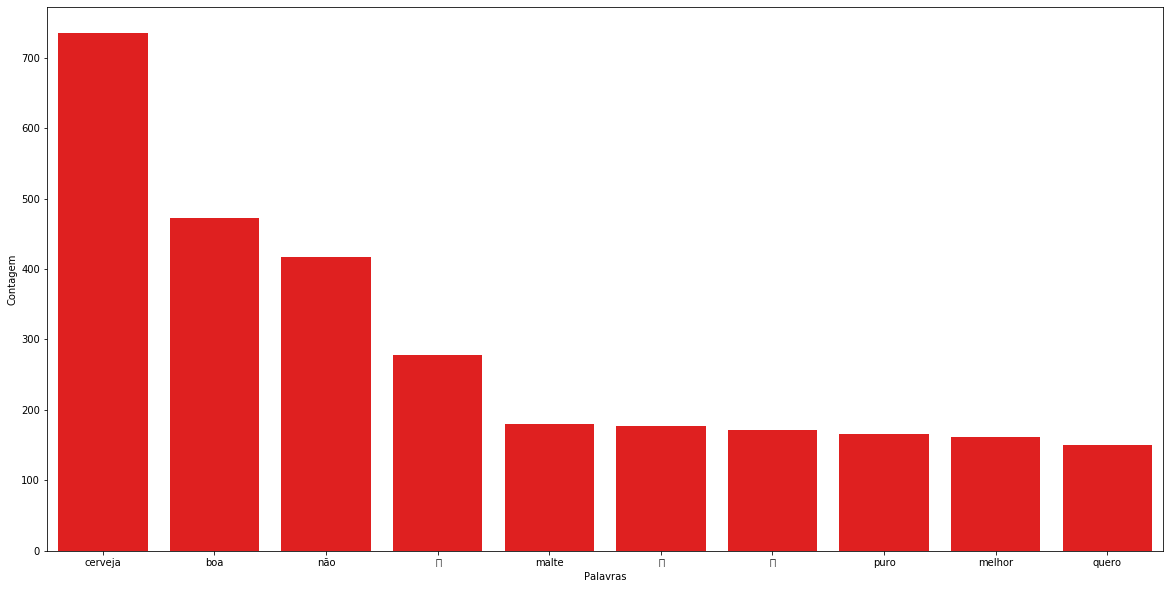

In [110]:
def pareto(coluna_texto, quantidade):
    palavras = ' '.join([texto for texto in coluna_texto])
    palavras = token_nltk.tokenize(palavras)
    frequencia = nltk.FreqDist(palavras)
    Comentarios_frequencia = pd.DataFrame({"Palavras": list(frequencia.keys()), "Frequencia": list(frequencia.values())})
    Comentarios_frequencia = Comentarios_frequencia.nlargest(columns="Frequencia", n=quantidade)
    plt.figure(figsize=(20, 10))
    ax = sns.barplot(data=Comentarios_frequencia, x="Palavras", y="Frequencia", color='red')
    ax.set(ylabel="Contagem")
    ax
    
pareto(Comentarios.comentarios_3, 10)

In [111]:
Comentarios.drop('comentarios_1', axis=1, inplace=True)
Comentarios.drop('comentarios_2', axis=1, inplace=True)
Comentarios.drop('comentarios_3', axis=1, inplace=True)

**Comentários com mais elementos positivos**

In [112]:
Comentarios.sort_values(by='pontuacao', ascending=False).head()

,Nome,comentarios,classificacao,pontuacao
3986,Vagner Justino,Essa é a verdadeira.😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍🎈🎈🎈🎈😎😎😎😎😎,Positivo,25
1246,Alexandre Santos,Show.de bola muito bom festa junina com boa ce...,Positivo,16
5501,Adriano Alice Wisnievski,Adriano Alice Wisnievski meu esposo Adriano el...,Positivo,12
3829,Thamaris Leão,"Eu amo 1500, melhor cerveja 😋😋😋Quero muito a t...",Positivo,11
4194,Vanessa Nascimento,Eita a hr q eu te pegar miserávi😍😍😍😍😍😍😍😍😍😍😍,Positivo,11


**Comentários com mais elementos negativos**

In [113]:
Comentarios.sort_values(by='pontuacao', ascending=True).head(15)

,Nome,comentarios,classificacao,pontuacao
1755,Fabiana Pontes,Por que vocês não vendem nos mercados do Rio d...,Negativo,-10
1643,Fernando Eduardo Neves,Quando eu tinha 12 anos minha mãe me obrigou a...,Negativo,-5
4800,Andreia Perez,Cansei de comprar engrado de 1500 de 12 e vim ...,Negativo,-5
4333,Dilecto Salvio,"Difícil é achar. Em SP, capital já fui no Walm...",Negativo,-4
1818,Jean R Mirandola,Pena que estragaram a cerveja pelo menos aqui ...,Negativo,-4
5187,Dilecto Salvio,Aqui em SP só achei no Walmart Pacaembú uma ún...,Negativo,-4
4791,José Gilberto Garuf,Caramba eu com a boca seca doido para tomar um...,Negativo,-3
1820,Eunice Rocha Saccol,Pena que aqui na região de Santiago/RS eu não ...,Negativo,-3
2214,Carol Fontes,O Duro é amar essa cerveja e não encontrar em ...,Negativo,-3
1813,Marcos Andre,Pena que onde tem os caras estão cobrando muit...,Negativo,-3


**Total de comentários Positivos, Neutros e Negativos**

In [114]:
positivos = Comentarios[Comentarios['classificacao']=='Positivo'].shape
neutros = Comentarios[Comentarios['classificacao']=='Neutro'].shape
negativos = Comentarios[Comentarios['classificacao']=='Negativo'].shape
print('Total de comentários Positivos: {}, Neutros: {}, Negativos: {}'.format(positivos[0], neutros[0], negativos[0]))

Total de comentários Positivos: 2292, Neutros: 2072, Negativos: 365


**Pessoas que mais comentaram**

In [115]:
Comentarios.Nome.value_counts().head(10)

Raf Fayad                         81
1500 Cerveja Puro Malte           51
Silvio Vince                      37
Sueli Duarte Nunes                37
Joao Sergio Pelegrina Minharro    24
Luciano Tellis                    22
Gyll Lopes                        19
Carlos Consoni                    17
Katia Patricia Mohr               17
Julio Cesar Treano                14
Name: Nome, dtype: int64

**Alguns tipos de comentários frequentes e interessantes**

In [116]:
#Comentários sobre versão puro malte
puromalte = list()
for comentario in Comentarios.comentarios:
    comentario = comentario.lower()
    i = nlp(comentario)
    for palavra in i:
        if palavra.text == "malte" or palavra.text == "puro":
            puromalte.append(comentario)

In [117]:
#Comentários sobre a taça burguesa
taca = list()
for comentario in Comentarios.comentarios:
    comentario = comentario.lower()
    i = nlp(comentario)
    for palavra in i:
        if palavra.text == "taça":
            taca.append(comentario)

In [118]:
#Comentários sobre o atendimento
atendimento = list()
for comentario in Comentarios.comentarios:
    comentario = comentario.lower()
    i = nlp(comentario)
    for palavra in i:
        if palavra.text == "atendimento" or palavra.text == "contato" or palavra.text == "atende" or palavra.text == "atender" or palavra.text == "responder" or palavra.text == "responde" or palavra.text == "vendedores" or palavra.text == "vender" or palavra.text == "revender" or palavra.text == "revenda":
            atendimento.append(comentario)

In [119]:
#Comentários sobre onde comprar
comprar = list()
for comentario in Comentarios.comentarios:
    comentario = comentario.lower()
    i = nlp(comentario)
    for palavra in i:
        if palavra.text == "encontro" or palavra.text == "encontrar" or palavra.text == "achar" or palavra.text == "cidade" or palavra.text == "comprar" or palavra.text == "compra":
            comprar.append(comentario)

In [120]:
comprar

['ótima cerveja e péssimo marketing!!! como sempre é muito difícil encontrar nos mercados.',
 'ótimo cerveja só que não tem na minha cidade matao sp.',
 'ótima cerveja quando encontro não tem pra ninguém é a minha primeira escolha',
 'é muito boa, mas difícil de achar  😨😨😨😨',
 'é muito boa mesmo...só encontro em dois supermercados aqui de interlagos...não é comum achar essa cerveja....',
 'é muito boa mesmo...só encontro em dois supermercados aqui de interlagos...não é comum achar essa cerveja....',
 'é boa mas difícil de encontrar no sudeste, precisa melhorar a distribuição',
 'é tão boa só que em porto alegre nadaaaaaaaaaaaaaaaaaaaaaaaaaa, eu quero comprar essa ceva aqui em poa e ninguém vende e nem sabe que existe, pessoal, por favor, ajudem e exportem para porto alegre.',
 'è boa, ruim de achar!',
 'tesouro mesmo... nunca mais achei pra compra :( ...',
 'tem um sabor suave gostei acho que vou comprar mais veses.',
 'ta dificil achar burguesa aq em araras sp',
 'sou de sorocaba sp o

In [121]:
len(taca)

43

In [122]:
len(puromalte)

345

In [123]:
len(atendimento)

49

In [124]:
len(comprar)

435

In [125]:
#Comentários sobre o atendimento e falta de produto
atendimento_produto = list()
for comentario in Comentarios.comentarios:
    comentario = comentario.lower()
    i = nlp(comentario)
    for palavra in i:
        if palavra.text == "atendimento" or palavra.text == "contato" or palavra.text == "atende" or palavra.text == "atender" or palavra.text == "responder" or palavra.text == "responde" or palavra.text == "vendedores" or palavra.text == "vender" or palavra.text == "revender" or palavra.text == "revenda" or palavra.text == "encontro" or palavra.text == "encontrar" or palavra.text == "achar" or palavra.text == "cidade" or palavra.text == "comprar" or palavra.text == "compra":
            atendimento_produto.append(comentario)

In [128]:
atendimento_produto_1500 = pd.DataFrame(atendimento_produto, columns=['comentarios'])
atendimento_produto_1500.to_csv('atendimento_produto_1500.csv')

In [127]:
atendimento_produto_1500

,comentarios
0,坂井 ロベルト clovis souza já coloca aí pra vender e...
1,ótima cerveja e péssimo marketing!!! como semp...
2,ótimo cerveja só que não tem na minha cidade m...
3,ótima cerveja quando encontro não tem pra ning...
4,"é muito boa, mas difícil de achar 😨😨😨😨"
...,...
479,a cerveja eh excelente ... mais como consigo c...
480,a cerveja ate q e boa mas nao e todo lugar q a...
481,1500 motivos para degustar uma iguaria dessas!...
482,"1500 cerveja puro malte, bem que eu queria, ma..."
